In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')

In [2]:
# File paths
IN_POS_FILE = '../feature_data/input_positions.csv'
IN_POS_FILE_TEST = '../feature_data/input_positions_test.csv'
OUT_POS_FILE = '../feature_data/output_positions.csv'
IN_VEL_FILE = '../feature_data/input_velocities.csv'
IN_VEL_FILE_TEST = '../feature_data/input_velocities_test.csv'
OUT_VEL_FILE = '../feature_data/output_velocities.csv'

# Keys to the pickle objects
CITY = 'city'
LANE = 'lane'
LANE_NORM = 'lane_norm'
SCENE_IDX = 'scene_idx'
AGENT_ID = 'agent_id'
P_IN = 'p_in'
V_IN = 'v_in'
P_OUT = 'p_out'
V_OUT = 'v_out'
CAR_MASK = 'car_mask'
TRACK_ID = 'track_id'

MIA = 'MIA'
PIT = 'PIT'
BOTH = 'both'
CITY_OPTIONS = {MIA, PIT, BOTH}

TARGET = 'target'
OTHER = 'other'
ALL = 'all'
AGENT_OPTIONS = {TARGET, OTHER, ALL}

# Column headers in the CSV files
WAS_TARGET = 'was_target'
P_IN_X = ['p_in_x' + str(i) for i in range(1, 20)]
P_IN_Y = ['p_in_y' + str(i) for i in range(1, 20)]
P_OUT_X = ['p_out_x' + str(i) for i in range(1, 31)]
P_OUT_Y = ['p_out_y' + str(i) for i in range(1, 31)]
V_IN_X = ['v_in_x' + str(i) for i in range(1, 20)]
V_IN_Y = ['v_in_y' + str(i) for i in range(1, 20)]
V_OUT_X = ['v_out_x' + str(i) for i in range(1, 31)]
V_OUT_Y = ['v_out_y' + str(i) for i in range(1, 31)]

In [3]:
def describe(a, desc):
    print(f"{desc}")
    print(f"min = {np.min(a)}")
    print(f"max = {np.max(a)}")
    print(f"mean = {np.mean(a)}")
    print(f"median = {np.median(a)}")
    print(f"standard deviation = {np.std(a)}\n")
    print(f"25th quantile = {np.quantile(a, 0.25)}\n")
    print(f"75th quantile = {np.quantile(a, 0.75)}\n")


In [4]:
def plot_hist(x, y, bins, title, palette, xlbl, ylbl, fname):
    """
    Plots a histogram of the two arrays x and y.
    """
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.set_palette(palette)
    sns.histplot(ax=ax1, x=x, y=y, bins=bins, cbar=True)
    ax1.set_xlabel(xlbl)
    ax1.set_ylabel(ylbl);
    ax1.set_title(title);
    plt.savefig(fname)

In [5]:
def get_pos_vel(data, agent_option, city_option, key):
    """
    Returns a NumPy array of one of the following, specified by the "key" parameter
    1. input/output x position
    2. input/output y position
    3. input/output x velocity
    4. input/output y velocity
    
    data: the DataFrame containing the values to select from
    agent_option: whether to return values for only the target agent, other agents, or all agents
    city_option: whether to return values for just one city or both cities
    key: the columns to get from the DataFrame  
    """
    assert agent_option in AGENT_OPTIONS
    assert city_option in CITY_OPTIONS
    
    # Filter by city
    df = None
    if city_option == MIA:
        df = data[data[CITY] == MIA]
    elif city_option == PIT:
        df = data[data[CITY] == PIT]
    else:
        df = data       
    
    # Filter by group and key values
    vals = None    
    if agent_option == TARGET:
        vals = df[df[WAS_TARGET] == 1][key].to_numpy()
    elif agent_option == OTHER:
        vals = df[df[WAS_TARGET] == 0][key].to_numpy()
    else:
        vals = df[key].to_numpy()
    # Make array one-dimensional
    vals = vals.reshape(vals.shape[0] * vals.shape[1])
    
    return vals

In [6]:
def compare_pos_vel(df, kx, ky, miami_title, pit_title):
    mxpos = get_pos_vel(df, ALL, MIA, kx)
    mypos = get_pos_vel(df, ALL, MIA, ky)
    pxpos = get_pos_vel(df, ALL, PIT, kx)
    pypos = get_pos_vel(df, ALL, PIT, ky)
    
    ax = sns.histplot(x=mxpos, y=mypos)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(miami_title)
    plt.show()
    
    ax = sns.histplot(x=pxpos, y=pypos)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(pit_title)
    plt.show()

# Input and Output Positions

In [7]:
indf = pd.read_csv(IN_POS_FILE)

In [9]:
pxin = get_pos_vel(indf, TARGET, BOTH, P_IN_X)
pyin = get_pos_vel(indf, TARGET, BOTH, P_IN_Y)

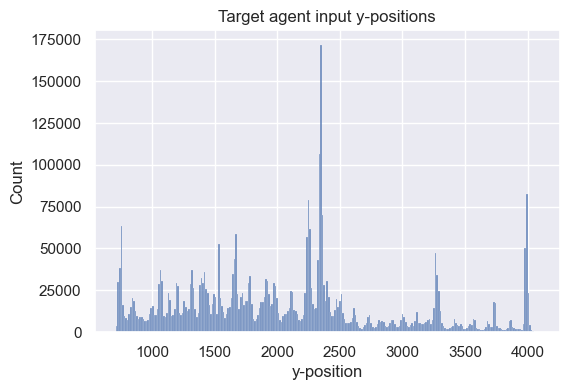

In [13]:
ax = sns.histplot(x=pyin);
ax.set_xlabel('y-position')
ax.set_title('Target agent input y-positions');

In [14]:
inmx = get_pos_vel(indf, ALL, MIA, P_IN_X)
inmy = get_pos_vel(indf, ALL, MIA, P_IN_Y)
inpx = get_pos_vel(indf, ALL, PIT, P_IN_X)
inpy = get_pos_vel(indf, ALL, PIT, P_IN_Y)

In [18]:
cities = ['Miami' for i in range(len(inmx))] + ['Pittsburgh' for i in range(len(inpx))]

In [19]:
temp_df = pd.DataFrame({
    'px': np.concatenate((inmx, inpx)),
    'py': np.concatenate((inmy, inpy)),
    'city': cities
})

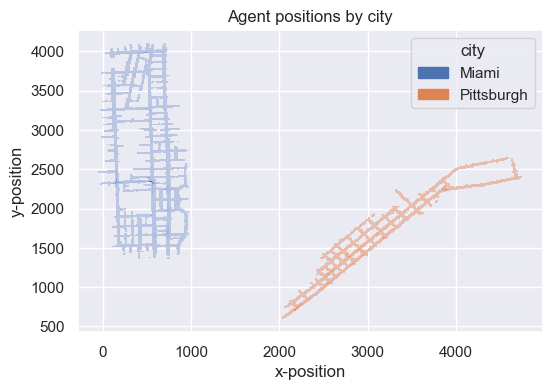

In [22]:
ax = sns.histplot(x='px', y='py', hue='city', data=temp_df);
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_title('Agent positions by city');

In [23]:
outdf = pd.read_csv(OUT_POS_FILE)

In [25]:
px = get_pos_vel(outdf, TARGET, BOTH, P_OUT_X)
py = get_pos_vel(outdf, TARGET, BOTH, P_OUT_Y)

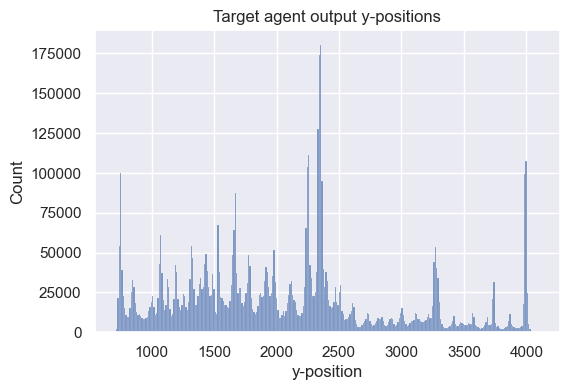

In [27]:
ax = sns.histplot(x=py);
ax.set_xlabel('y-position')
ax.set_title('Target agent output y-positions');

In [28]:
outmx = get_pos_vel(outdf, ALL, MIA, P_OUT_X)
outmy = get_pos_vel(outdf, ALL, MIA, P_OUT_Y)
outpx = get_pos_vel(outdf, ALL, PIT, P_OUT_X)
outpy = get_pos_vel(outdf, ALL, PIT, P_OUT_Y)

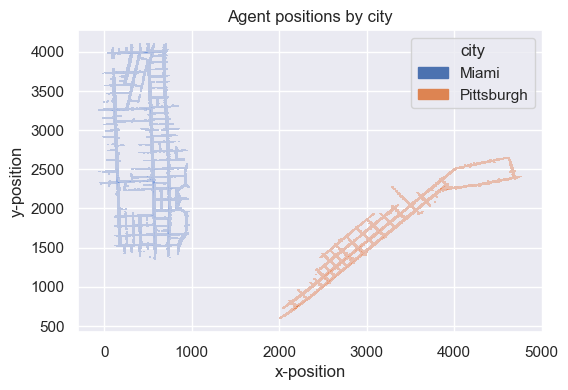

In [29]:
cities = ['Miami' for i in range(len(outmx))] + ['Pittsburgh' for i in range(len(outpx))]

temp_df = pd.DataFrame({
    'px': np.concatenate((outmx, outpx)),
    'py': np.concatenate((outmy, outpy)),
    'city': cities
})

ax = sns.histplot(x='px', y='py', hue='city', data=temp_df);
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_title('Agent positions by city');

In [33]:
# # describe(inmx, 'pxin, MIA')
# # describe(inmy, 'pyin, MIA')
# describe(outmx, 'pxout, MIA')
# describe(outmy, 'pyout, MIA')

# # describe(inpx, 'pxin, PIT')
# # describe(inpy, 'pyin, PIT')
# describe(outpx, 'pxout, PIT')
# describe(outpy, 'pyout, PIT')

In [34]:
# agg_mx = np.concatenate((inmx, outmx))
# describe(agg_mx, 'input/output x pos miami')

In [35]:
# agg_my = np.concatenate((inmy, outmy))
# describe(agg_my, 'input/output y pos miami')

In [36]:
# agg_px = np.concatenate((inpx, outpx))
# describe(agg_px, 'input/output x pos PIT')

In [37]:
# agg_py = np.concatenate((inpy, outpy))
# describe(agg_py, 'input/output y pos PIT')

In [30]:
indf = pd.read_csv(IN_VEL_FILE)

In [31]:
outdf = pd.read_csv(OUT_VEL_FILE)

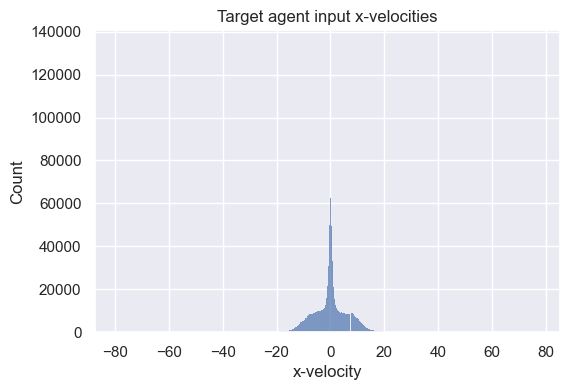

In [47]:
x = get_pos_vel(indf, TARGET, BOTH, V_IN_X)
y = get_pos_vel(indf, TARGET, BOTH, V_IN_Y)

ax = sns.histplot(x=x, bins=2000);
ax.set_xlabel('x-velocity')
ax.set_title('Target agent input x-velocities');

In [52]:
inmx = get_pos_vel(indf, ALL, MIA, V_IN_X)
inmy = get_pos_vel(indf, ALL, MIA, V_IN_Y)
inpx = get_pos_vel(indf, ALL, PIT, V_IN_X)
inpy = get_pos_vel(indf, ALL, PIT, V_IN_Y)

In [53]:
outmx = get_pos_vel(outdf, ALL, MIA, V_OUT_X)
outmy = get_pos_vel(outdf, ALL, MIA, V_OUT_Y)
outpx = get_pos_vel(outdf, ALL, PIT, V_OUT_X)
outpy = get_pos_vel(outdf, ALL, PIT, V_OUT_Y)

MemoryError: Unable to allocate 15.6 GiB for an array with shape (2087125248,) and data type int64

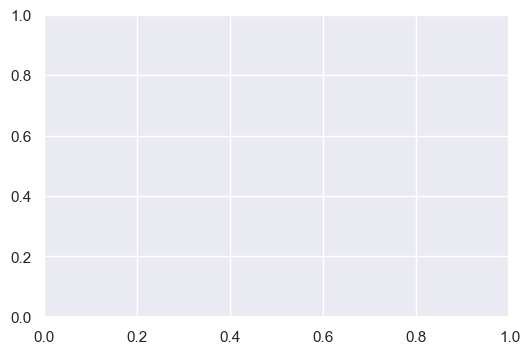

In [54]:
cities = ['Miami' for i in range(len(outmx))] + ['Pittsburgh' for i in range(len(outpx))]

temp_df = pd.DataFrame({
    'px': np.concatenate((outmx, outpx)),
    'py': np.concatenate((outmy, outpy)),
    'city': cities
})

ax = sns.histplot(x='px', y='py', hue='city', data=temp_df);
ax.set_xlabel('x-velocity')
ax.set_ylabel('y-velocity')
ax.set_title('Agent positions by city');

In [114]:
ttest_ind(inmx, outmx)

Ttest_indResult(statistic=21.503385982197685, pvalue=1.4487777829215645e-102)

In [48]:
# describe(inmx, 'pxin, MIA')
# describe(inmy, 'pyin, MIA')
# describe(outmx, 'pxout, MIA')
# describe(outmx, 'pyout, MIA')

# describe(inpx, 'pxin, PIT')
# describe(inpy, 'pyin, PIT')
# describe(outpx, 'pxout, PIT')
# describe(outpy, 'pyout, PIT')

In [49]:
# agg_mx = np.concatenate((inmx, outmx))
# describe(agg_mx, 'input/output x VEL miami')

In [110]:
# agg_my = np.concatenate((inmy, outmy))
# describe(agg_my, 'input/output y VEL miami')

input/output y VEL miami
min = -187.7124328613281
max = 194.3325042724609
mean = -0.4685357465116048
standard deviation = 5.881096421933545



In [50]:
# agg_px = np.concatenate((inpx, outpx))
# describe(agg_px, 'input/output x VEL PIT')

In [51]:
# agg_py = np.concatenate((inpy, outpy))
# describe(agg_py, 'input/output y VEL PIT')

In [ ]:
# Statistics for normalization - these were gathered from the EDA notebook files
PXIN_MIN = -46.95796585083008
PXIN_MAX = 4748.19482421875
PXIN_MEAN = 1475.1456442135957
PXIN_STD = 1283.2827969107375

PXOUT_MIN = -60.59521484375
PXOUT_MAX = 4772.96142578125
PXOUT_MEAN = 1475.5169279862944
PXOUT_STD = 1283.3762945780595

PYIN_MIN = 601.494384765625
PYIN_MAX = 4096.12841796875
PYIN_MEAN = 2175.9990297289187
PYIN_STD = 868.4950781169506

PYOUT_MIN = 595.7562255859375
PYOUT_MAX = 4097.95849609375
PYOUT_MEAN = 2175.5613156244103
PYOUT_STD = 867.833158763342

VXIN_MIN = -222.6323547363281
VXIN_MAX = 290.52691650390625
VXIN_MEAN = 0.16118329224158862
VXIN_STD = 4.566191005421228

VXOUT_MIN = -210.0390167236328
VXOUT_MAX = 193.1862945556641
VXOUT_MEAN = 0.14362513352257486
VXOUT_STD = 4.666555423675791

VYIN_MIN = -179.869384765625
VYIN_MAX = 270.28366088867193
VYIN_MEAN = -0.18538976897596968
VYIN_STD = 5.640785253866921

VYOUT_MIN = -187.7124328613281
VYOUT_MAX = 194.3325042724609
VYOUT_MEAN = -0.1731546750855955
VYOUT_STD = 5.754394486807422

LANEX_MIN = -75.96349
LANEX_MAX = 4791.5786
LANEX_MEAN = 1820.5659689101437
LANEX_STD = 1144.381723963882

LANEY_MIN = -75.64791
LANEY_MAX = 4791.5786
LANEY_MEAN = 1820.9785387658249
LANEY_STD = 1143.909722279091

NORMX_MIN = -18.56374
NORMX_MAX = 18.801159
NORMX_MEAN = -0.07494290028642103
NORMX_STD = 2.168031749477364

NORMY_MIN = -18.56374
NORMY_MAX = 18.801159
NORMY_MEAN = -0.07433357681873475
NORMY_STD = 2.172411638566323

In [ ]:
# Statistics grouped by city - since input and output positions are so similar, they are aggregated
# Note that the t-test reports significane even for in/out for the same city
input/output x pos miami
min = -60.59521484375
max = 966.2291259765624
mean = 494.0619757866361
median = 548.2406616210939
standard deviation = 214.1981918513561

input/output y pos miami
min = 1348.4622802734375
max = 4097.95849609375
mean = 2626.472026863601
median = 2354.357666015625
standard deviation = 752.703082539177

input/output x pos PIT
min = 2011.815673828125
max = 4772.96142578125
mean = 2983.2778791901637
median = 2841.2412109375
standard deviation = 594.7421583094941

input/output y pos PIT
min = 595.7562255859375
max = 2648.844482421875
mean = 1483.11212750103
median = 1404.4364013671875
standard deviation = 499.04285978143486

input/output x VEL miami
min = -222.6323547363281
max = 228.33824157714844
mean = 0.08634114372910447
standard deviation = 3.316648463898035

input/output y VEL miami
min = -187.7124328613281
max = 194.3325042724609
mean = -0.4685357465116048
standard deviation = 5.881096421933545

input/output x VEL PIT
min = -187.45199584960938
max = 290.52691650390625
mean = 0.24891902567428928
standard deviation = 6.116291787218023

input/output y VEL PIT
min = -148.76397705078125
max = 270.28366088867193
mean = 0.2687003422795324
standard deviation = 5.407882762084837